In [70]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
from lightfm import LightFM
import ipdb
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix 
from sklearn.metrics import roc_auc_score
import time
from lightfm.evaluation import auc_score
import pickle
import matplotlib as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation

#import plotly.plotly as py
#from plotly.graph_objs import *
#from matplotlib import pyplot

#%matplotlib nbagg

def create_data(datapath,start_date,end_date):
    df=pd.read_csv(datapath)
    df=df.assign(date=pd.Series(datetime.fromtimestamp(a/1000).date() for a in df.timestamp))
    df=df.sort_values(by='date').reset_index(drop=True) # for some reasons RetailRocket did NOT sort data by date
    df=df[(df.date>=datetime.strptime(start_date,'%Y-%m-%d').date())&(df.date<=datetime.strptime(end_date,'%Y-%m-%d').date())]
    df=df[['visitorid','itemid','event']]
    return df

def create_implicit_feedback_matrix(df, split_ratio):
    # assume df.columns=['visitorid','itemid','event']
    id_cols=['visitorid','itemid']
    trans_cat=dict()
    for k in id_cols:
        cate_enc=preprocessing.LabelEncoder()
        trans_cat[k]=cate_enc.fit_transform(df[k].values)
    cate_enc=preprocessing.LabelEncoder()
    ratings=cate_enc.fit_transform(df.event) 
    n_users=len(np.unique(trans_cat['visitorid']))
    n_items=len(np.unique(trans_cat['itemid']))    
    split_point=np.int(np.round(df.shape[0]*split_ratio))
    
    rate_matrix=dict()
    rate_matrix['train']=coo_matrix((ratings[0:split_point],(trans_cat['visitorid'][0:split_point],\
                                              trans_cat['itemid'][0:split_point]))\
                             ,shape=(n_users,n_items))
    rate_matrix['test']=coo_matrix((ratings[split_point+1::],(trans_cat['visitorid'][split_point+1::],\
                                              trans_cat['itemid'][split_point+1::]))\
                             ,shape=(n_users,n_items))
    return rate_matrix

def create_implicit_feedback_matrix1(df, split_ratio):
    # assume df.columns=['visitorid','itemid','event']
    split_point=np.int(np.round(df.shape[0]*split_ratio))
    df_train=df.iloc[0:split_point]
    df_test=df.iloc[split_point::]
    df_test=df_test[(df_test['visitorid'].isin(df_train['visitorid']))&\
                     (df_test['itemid'].isin(df_train['itemid']))]
    id_cols=['visitorid','itemid']
    trans_cat_train=dict()
    trans_cat_test=dict()
    for k in id_cols:
        cate_enc=preprocessing.LabelEncoder()
        trans_cat_train[k]=cate_enc.fit_transform(df_train[k].values)
        trans_cat_test[k]=cate_enc.transform(df_test[k].values)
    
    # --- Encode ratings:
    cate_enc=preprocessing.LabelEncoder()
    ratings=dict()
    ratings['train']=cate_enc.fit_transform(df_train.event)
    ratings['test'] =cate_enc.transform(df_test.event)
    
    n_users=len(np.unique(trans_cat_train['visitorid']))
    n_items=len(np.unique(trans_cat_train['itemid']))    
    
    
    rate_matrix=dict()
    rate_matrix['train']=coo_matrix((ratings['train'],(trans_cat_train['visitorid'],\
                                              trans_cat_train['itemid']))\
                             ,shape=(n_users,n_items))
    rate_matrix['test']=coo_matrix((ratings['test'],(trans_cat_test['visitorid'],\
                                              trans_cat_test['itemid']))\
                             ,shape=(n_users,n_items))
    return rate_matrix

if __name__=='__main__':
    start_time = time.time()
    df=create_data('./data/events.csv','2015-5-3','2015-5-18')
    modelLoad=False
    rating_matrix=create_implicit_feedback_matrix1(df,.8)
    if(modelLoad):
        with open('saved_model','rb') as f:
            saved_model=pickle.load(f)
            model=saved_model['model']
    else:
        model=LightFM(no_components=5,loss='warp')
        model.fit(rating_matrix['train'],epochs=100,num_threads=1)
        with open('saved_model','wb') as f:
            saved_model={'model':model}
            pickle.dump(saved_model, f)
    auc_train = auc_score(model, rating_matrix['train']).mean()
    auc_test = auc_score(model, rating_matrix['test']).mean()
    
    #df=df.assign(pred_score=model.predict(df['visitorid'],df['itemid']))
    
    #df_auc=df.groupby(by='visitorid').apply(lambda df: roc_auc_score(df['event'].values,df['pred_score'].values))
    #print('Training auc %0.3f' % numpy.mean([i for i in df_auc.values if i > -1]))
    
    print("--- Run time:  %s mins ---\n" % ((time.time() - start_time)/60))
    print("Train AUC %.3f\n"%auc_train)
    print("Test AUC %.3f\n"%auc_test)
    

--- Run time:  3.946610494454702 mins ---

Train AUC 0.984

Test AUC 0.821



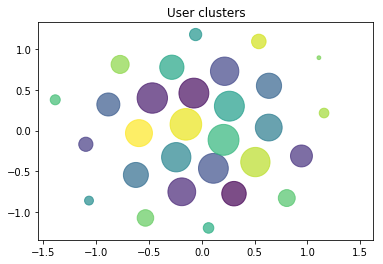

In [81]:
from matplotlib import pyplot

user_p=model.get_user_representations()

pca=PCA(n_components=2)
pca_fit=pca.fit_transform(user_p[1])

c_model=KMeans(30)
c_model.fit(pca_fit)
labels=pd.DataFrame(c_model.predict(pca_fit),columns=['label'])
labels=labels.groupby('label').size().to_frame('label_size')
labels=(labels-labels.min())/(labels.max()-labels.min())
centers=c_model.cluster_centers_

pyplot.figure()
pyplot.scatter(centers[:,0],centers[:,1],s=1000*labels.values,c=labels.index,alpha=0.7)
pyplot.title('User clusters')
pyplot.show()


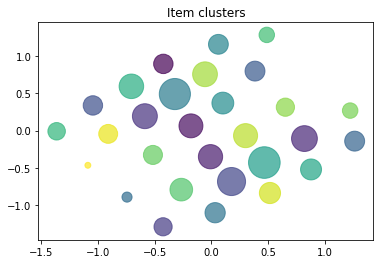

In [82]:
item_p=model.get_item_representations()

pca=PCA(n_components=2)
pca_fit=pca.fit_transform(item_p[1])

c_model=KMeans(30)
c_model.fit(pca_fit)
labels=pd.DataFrame(c_model.predict(pca_fit),columns=['label'])
labels=labels.groupby('label').size().to_frame('label_size')
labels=(labels-labels.min())/(labels.max()-labels.min())
centers=c_model.cluster_centers_

pyplot.figure()
pyplot.scatter(centers[:,0],centers[:,1],s=1000*labels.values,c=labels.index,alpha=0.7)
pyplot.title('Item clusters')
pyplot.show()